In [1]:
%cd motionmapperpyOther

!python setup.py install

%cd ..


C:\Users\18313\MonkeyTestRepo\motionmapperpyOther
running install
running bdist_egg
running egg_info
writing motionmapperpy.egg-info\PKG-INFO
writing dependency_links to motionmapperpy.egg-info\dependency_links.txt
writing requirements to motionmapperpy.egg-info\requires.txt
writing top-level names to motionmapperpy.egg-info\top_level.txt
reading manifest file 'motionmapperpy.egg-info\SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'motionmapperpy.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\motionmapperpy
copying build\lib\motionmapperpy\mmutils.py -> build\bdist.win-amd64\egg\motionmapperpy
copying build\lib\motionmapperpy\motionmapper.py -> build\bdist.win-amd64\egg\motionmapperpy
copying build\lib\motionmapperpy\setrunparameters.py -> build\bdist.win-amd64\egg\motionmapperpy
copying build\lib\motionmapperpy\wavelet.py -> build\bdi

C:\Users\18313\anaconda3\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
C:\Users\18313\anaconda3\lib\site-packages\setuptools\command\easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
zip_safe flag not set; analyzing archive contents...
error: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\users\\18313\\anaconda3\\lib\\site-packages\\motionmapperpy-1.0-py3.9.egg'


In [2]:
%load_ext autoreload
%autoreload 2

In [478]:
import pandas as pd
import numpy as np
import pickle 

import glob, os, sys

import time, copy
from datetime import datetime
import hdf5storage

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from tqdm import tqdm 

from scipy.ndimage import median_filter

from matplotlib import rc
rc('animation', html='jshtml')

from pythonlib.dataset.dataset import Dataset
from pythonlib.dataset.dataset_preprocess.general import preprocessDat

import motionmapperpy as mmpy

from pythonlib.tools.expttools import makeTimeStamp, writeDictToYaml

import extraFunctions as ef




#add these to testMonkey1
from IPython.display import Image
import random
from pythonlib.drawmodel import strokePlots
import math


In [46]:
ts = makeTimeStamp()

In [47]:
projectPath = f'content/trial1_mmpy{ts}'

# This creates a project directory structure which will be used to store all motionmappery pipeline
# related data in one place.

mmpy.createProjectDirectory(projectPath)


Creating : content/trial1_mmpy220721_123201
Creating : content/trial1_mmpy220721_123201/Projections
Creating : content/trial1_mmpy220721_123201/TSNE_Projections
Creating : content/trial1_mmpy220721_123201/TSNE
Creating : content/trial1_mmpy220721_123201/UMAP


In [26]:
%matplotlib inline

In [7]:
expt = 'gridlinecircle'
path_list = [
    "data_030421/Pancho-gridlinecircle-baseline-210824_002447",
    "data_030421/Pancho-gridlinecircle-circletoline-210828_100027",
    "data_030421/Pancho-gridlinecircle-linetocircle-210828_100152",
    "data_030421/Pancho-gridlinecircle-lolli-210903_094051",
]
append_list = None

In [48]:
parameters = mmpy.setRunParameters()


In [146]:
# %%%%%%% PARAMETERS TO CHANGE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# These need to be revised everytime you are working with a new dataset. #

parameters.projectPath = projectPath #% Full path to the project directory.


#parameters.method = 'UMAP' #% We can choose between 'TSNE' or 'UMAP'

parameters.minF = 1        #% Minimum frequency for Morlet Wavelet Transform

parameters.maxF = 25       #% Maximum frequency for Morlet Wavelet Transform,
                           #% usually equal to the Nyquist frequency for your
                           #% measurements.

parameters.samplingFreq = 100    #% Sampling frequency (or FPS) of data.

parameters.numPeriods = 25       #% No. of dyadically spaced frequencies to
                                 #% calculate between minF and maxF.
comps_above_thresh = 2
parameters.pcaModes = comps_above_thresh #% Number of low-d features.

parameters.numProcessors = -1     #% No. of processor to use when parallel
                                 #% processing for wavelet calculation (if not using GPU)  
                                 #% and for re-embedding. -1 to use all cores 
                                 #% available.

parameters.useGPU = -1           #% GPU to use for wavelet calculation, 
                                 #% set to -1 if GPU not present.

parameters.training_numPoints = 10000   #% Number of points in mini-trainings.


# %%%%% NO NEED TO CHANGE THESE UNLESS MEMORY ERRORS OCCUR %%%%%%%%%%

parameters.trainingSetSize = 5000  #% Total number of training set points to find. 
                                 #% Increase or decrease based on
                                 #% available RAM. For reference, 36k is a 
                                 #% good number with 64GB RAM.

parameters.embedding_batchSize = 30000  #% Lower this if you get a memory error when 
                                        #% re-embedding points on a learned map.

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# %%%%%%% tSNE parameters %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#% can be 'barnes_hut' or 'exact'. We'll use barnes_hut for this tutorial for speed.
parameters.tSNE_method = 'barnes_hut' 

# %2^H (H is the transition entropy)
parameters.perplexity = 32

# %number of neigbors to use when re-embedding
parameters.maxNeighbors = 200

# %local neighborhood definition in training set creation
parameters.kdNeighbors = 5

# %t-SNE training set perplexity
parameters.training_perplexity = 20

writeDictToYaml(parameters, projectPath+'/parameters.yaml')

In [147]:
#add this line to see stuff from other files
parameters.projectPath = 'content/trial1_mmpy220721_123201'

In [148]:
parameters.projectPath

'content/trial1_mmpy220721_123201'

In [11]:
# function to get data in the form of array dataTotal
def get_dataTotal(D):
    # x is the trial index there are 5125 trials so x < 5125
    x = 0
    # y is the stroke index- we dont know how many strokes r there
    y = 0
    # i is the index of one time frame of one stroke, 
    # this index also varies for each trial and stroke
    i = 0
    #ldataOneStroke = np.array([])
    #dataTotal = np.empty([150,1])
    ldataOneStroke = []
    ldataOneTrial = []
    ldataTotal = []
    #len(D.Dat)
    x=0
    for x in range(len(D.Dat)):
        y=0
        ldataOneTrial = []
        for y in range(len(D.Dat.iloc[x]["strokes_beh"])):
            #print(len(D.Dat.iloc[x]["strokes_beh"]))
            i=0
            ldataOneStroke = []
            for i in range(i,len(D.Dat.iloc[x]["strokes_beh"][y])):
                temp = D.Dat.iloc[x]["strokes_beh"][y][i][0:2]
                ldataOneStroke.append(temp)
            #print(len(ldataOneStroke))
            dataOneStroke = np.array(ldataOneStroke)
            #print(dataOneStroke)
            #ldataOneTrial = np.append(ldataOneTrial,ldataOneStroke)
            ldataOneTrial.append(dataOneStroke)
        #print(len(ldataOneTrial))    
        dataOneTrial = np.array(ldataOneTrial)
        ldataTotal.append(dataOneTrial)
        #ldataTotal = np.append(ldataTotal,ldataOneTrial)
        #dataOneTrial = np.vstack((dataOneTrial, dataOneStroke))
    dataTotal = np.array(ldataTotal)
    return dataTotal

In [12]:
# function to get list of strokes indexes
def get_strokeIndexes(dataTotal):
    list_trialstroke = []
    for trial, x in enumerate(dataTotal):
        #print(len(x))
        for strokenum, xx in enumerate(x):
            list_trialstroke.append((trial, strokenum))
    return list_trialstroke

In [13]:
# function to get list of 
# num should not be more than 5125
def get_strokes(dataTotal,num):
    #ndata = len(dataTotal)
    ndata = num

    lindependentStrokes = []
    for x in range(ndata):
        for y in range(len(dataTotal[x])):
            temp = dataTotal[x][y]
            lindependentStrokes.append(temp)
    #independentStrokes = np.array(lindependentStrokes)
    return lindependentStrokes

In [149]:
def sub_tsne(parameters):
    mmpy.subsampled_tsne_from_projections(parameters, parameters.projectPath)
    #print("HERE1") 


In [283]:
def total_tsne(parameters):
    #tsne takes 19 mins
    tall = time.time()

    import h5py
    tfolder = parameters.projectPath+'/%s/'%parameters.method

    # Loading training data
    with h5py.File(tfolder + 'training_data.mat', 'r') as hfile:
        trainingSetData = hfile['trainingSetData'][:].T

    # Loading training embedding
    with h5py.File(tfolder+ 'training_embedding.mat', 'r') as hfile:
        trainingEmbedding= hfile['trainingEmbedding'][:].T

    if parameters.method == 'TSNE':
        zValstr = 'zVals' 
    else:
        zValstr = 'uVals'



    projectionFiles = glob.glob(parameters.projectPath+'/Projections/*notpca.mat')



    for i in range(len(projectionFiles)):
        print('Finding Embeddings')
        t1 = time.time()
        print('%i/%i : %s'%(i+1,len(projectionFiles), projectionFiles[i]))


        # Skip if embeddings already found.
        if os.path.exists(projectionFiles[i][:-4] +'_%s.mat'%(zValstr)):
            print('Already done. Skipping.\n')
            continue

        # load projections for a dataset
        #modifying adding np.array
        projections = np.array(hdf5storage.loadmat(projectionFiles[i])['projections'])

        # Find Embeddings
        zValues, outputStatistics = mmpy.findEmbeddings(projections,trainingSetData,trainingEmbedding,parameters)
        
        #print(zValues.shape())
        print(type(zValues))

        # Save embeddings
        hdf5storage.write(data = {'zValues':zValues}, path = '/', truncate_existing = True,
                        filename = projectionFiles[i][:-4]+'_%s.mat'%(zValstr), store_python_metadata = False,
                          matlab_compatible = True)

        # Save output statistics
        with open(projectionFiles[i][:-4] + '_%s_outputStatistics.pkl'%(zValstr), 'wb') as hfile:
            pickle.dump(outputStatistics, hfile)

        del zValues,projections,outputStatistics


    print('All Embeddings Saved in %i seconds!'%(time.time()-tall))

In [140]:
projectionFiles = glob.glob(parameters.projectPath+'/Projections/*notpca.mat')


In [143]:
pro = np.array(hdf5storage.loadmat(projectionFiles[0])['projections'])

KeyError: 'projections'

In [16]:
D = Dataset(path_list, append_list)

----------------
Currently loading: data_030421/Pancho-gridlinecircle-baseline-210824_002447
Loaded metadat:
{'sketchpad_edges': array([[-311.84, -224.8 ],
       [ 311.84,  429.6 ]]), 'metadat_probedat': {'sdate': 210820, 'edate': 210821, 'strokmodel_kind': None, 'strokmodel_tstamp': None, 'datecategories': {'210820': 1, '210821': 1}, 'dates_for_summary': [], 'matchedstrokes': None, 'exptnames': ['gridlinecircle1', 'gridlinecircle2'], 'T1': [], 'G1': [], 'G2': [], 'G3': [], 'G4': [], 'description': '', 'finalized': False, 'good_expt': True, 'expt': 'gridlinecircle', 'task_train_test': {'probe1_liketrain': 'train', 'probe1_nostrokeconstraint': 'train', 'probe2_liketrain': 'train', 'probe2_nostrokeconstraint': 'train', 'probe3_hdpos': 'test', 'probe1': 'train', 'probe2': 'train', 'probe3': 'test', 'probe4': 'test', 'train': 'train'}}, 'filedata_params': {'pix_per_deg': array([[ 26.64621164],
       [-26.64621164]]), 'resolution': (1024, 768), 'animal': 'Pancho', 'basedir': '/data2/anima

In [17]:
dataTotal = get_dataTotal(D)

C:\Users\18313\AppData\Local\Temp\ipykernel_47640\4208463306.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataOneTrial = np.array(ldataOneTrial)
C:\Users\18313\AppData\Local\Temp\ipykernel_47640\4208463306.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataTotal = np.array(ldataTotal)


In [18]:
list_trialstroke = get_strokeIndexes(dataTotal)

In [50]:
projections = get_strokes(dataTotal,10)


In [150]:
print('%s/Projections/test_monkey_notpca.mat'%(projectPath))


content/trial1_mmpy220721_123201/Projections/test_monkey_notpca.mat


In [151]:
hdf5storage.savemat('%s/Projections/test_monkey_notpca.mat'%(projectPath), {"projections" : projections})

#projectionFiles = glob.glob(parameters.projectPath+'/Projections/*test_monkey_notPCA.mat')

In [22]:
parameters

{'numProcessors': -1,
 'numPeriods': 25,
 'omega0': 5,
 'samplingFreq': 100,
 'minF': 1,
 'maxF': 25,
 'tSNE_method': 'barnes_hut',
 'perplexity': 32,
 'embedding_batchSize': 30000,
 'maxOptimIter': 100,
 'trainingSetSize': 5000,
 'maxNeighbors': 200,
 'kdNeighbors': 5,
 'training_perplexity': 20,
 'training_numPoints': 10000,
 'minTemplateLength': 1,
 'waveletDecomp': True,
 'useGPU': -1,
 'n_neighbors': 15,
 'train_negative_sample_rate': 5,
 'embed_negative_sample_rate': 1,
 'min_dist': 0.1,
 'umap_output_dims': 2,
 'n_training_epochs': 1000,
 'rescale_max': 100,
 'method': 'TSNE',
 'projectPath': 'content/trial1_mmpy220721_122012',
 'pcaModes': 2}

In [152]:
sub_tsne(parameters)

Finding Training Set
Subsampled trainingSetData found, skipping minitSNE and running training tSNE
Finding t-SNE Embedding for Training Set
Finding Distances
Computing t-SNE
[t-SNE] Computing 97 nearest neighbors...
[t-SNE] Indexed 211 samples in 0.001s...
[t-SNE] Computed neighbors for 211 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 211 / 211
[t-SNE] Mean sigma: 0.121554


C:\Users\18313\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\18313\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\18313\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.328194
[t-SNE] KL divergence after 1000 iterations: 0.035961


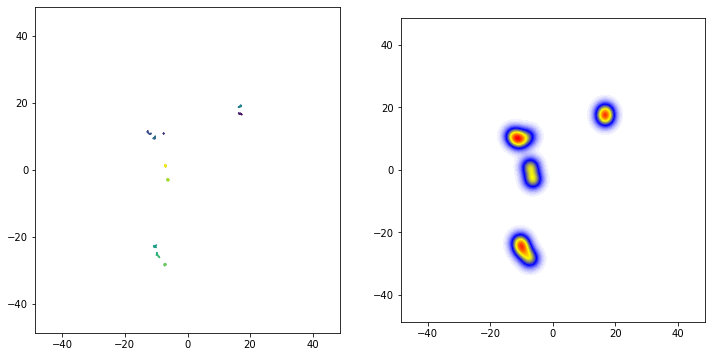

In [443]:
trainy = hdf5storage.loadmat('%s/%s/training_embedding.mat'%(parameters.projectPath, parameters.method))['trainingEmbedding']
m = np.abs(trainy).max()


sigma=2.0
_, xx, density = mmpy.findPointDensity(trainy, sigma, 511, [-m-20, m+20])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(trainy[:,0], trainy[:,1], marker='.', c=np.arange(trainy.shape[0]), s=1)
axes[0].set_xlim([-m-20, m+20])
axes[0].set_ylim([-m-20, m+20])

axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

In [474]:
total_tsne(parameters)

Finding Embeddings
1/1 : content/trial1_mmpy220721_123201/Projections\test_monkey_notpca.mat
Finding Wavelets
(10,)
(71, 2)
	 Calculating wavelets, clock starting.
	 Using #12 CPUs.


C:\Users\18313\AppData\Local\Temp\ipykernel_47640\3299719549.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  projections = np.array(hdf5storage.loadmat(projectionFiles[i])['projections'])


	 Done at 7.64 seconds.
(71, 50)
Finding Embeddings
	 Processing batch #   1 out of    1
	 Calculating distances for batch    1
	 Calculated distances for batch    1 0.00seconds.
	 Calculating fminProjections for batch    1
	 Processed batch #   1 out of    1 in 21.27seconds.

(71, 2)
Embeddings found in 21.28 seconds.
(78, 2)
	 Calculating wavelets, clock starting.
	 Using #12 CPUs.
	 Done at 8.59 seconds.
(78, 50)
Finding Embeddings
	 Processing batch #   1 out of    1
	 Calculating distances for batch    1
	 Calculated distances for batch    1 0.00seconds.
	 Calculating fminProjections for batch    1
	 Processed batch #   1 out of    1 in 18.57seconds.

(78, 2)
Embeddings found in 18.57 seconds.
(82, 2)
	 Calculating wavelets, clock starting.
	 Using #12 CPUs.
	 Done at 7.56 seconds.
(82, 50)
Finding Embeddings
	 Processing batch #   1 out of    1
	 Calculating distances for batch    1
	 Calculated distances for batch    1 0.00seconds.
	 Calculating fminProjections for batch    1
	 

In [56]:
zValstr = 'zVals'

In [287]:
glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr))

['content/trial1_mmpy220721_123201/Projections\\test_monkey_notpca_zVals.mat']

In [302]:
zV = hdf5storage.loadmat(glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr))[0])['zValues']

In [306]:
zV[0][1][0]

array([-12.32790994,  10.80323989])

In [431]:
#function to take zValues array and make an accessible array
def get_zValues_array(zV):
    zValues = []
    for i in range(len(zV)):
        item = zV[i][0]
        zValues.append(item)
    return zValues
        

In [447]:
ally

array([[-10.56136071, -22.96431161],
       [-12.32790994,  10.80323989],
       [ -7.11118232,   1.26771748],
       [ -6.264831  ,  -2.95446524],
       [-10.73188798,   9.590412  ],
       [ 16.78322154,  18.9802326 ],
       [ -7.53358647, -27.83943164],
       [ -8.03547075,  10.67427995],
       [ 16.78970724,  16.50337967],
       [ -9.61383084, -25.38527758]])

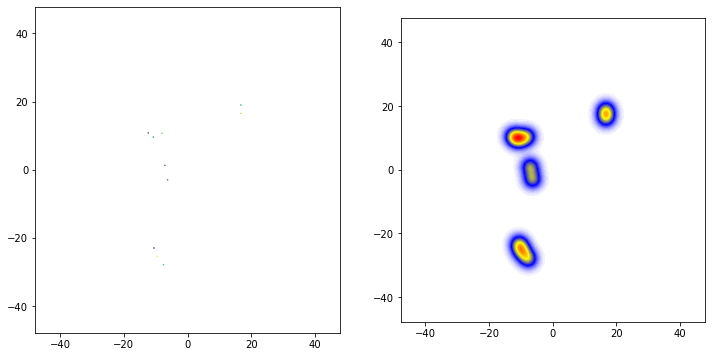

In [480]:
# load all the embeddings
#for i in glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr)):
#    ally = hdf5storage.loadmat(i)['zValues']
'''
ally = hdf5storage.loadmat(glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr))[0])['zValues'][0]


ally = get_zValues_array(ally)
ally = np.array(ally)
'''

ally = ef.get_zValues_array(parameters, zValstr)

m = np.abs(ally).max()

sigma=2.0
_, xx, density = mmpy.findPointDensity(ally, sigma, 511, [-m-20, m+20])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(ally[:,0], ally[:,1], marker='.', c=np.arange(ally.shape[0]), s=1)
axes[0].set_xlim([-m-20, m+20])
axes[0].set_ylim([-m-20, m+20])

axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')




In [472]:
ally[]

array([array([[-10.56136071]]), array([[-12.32790994]]),
       array([[-7.11118232]]), array([[-6.264831]]),
       array([[-10.73188798]]), array([[16.78322154]]),
       array([[-7.53358647]]), array([[-8.03547075]]),
       array([[16.78970724]]), array([[-9.61383084]])], dtype=object)

In [410]:
a = ally[0][0][0]

In [411]:
print(a)

[-10.56136071 -22.96431161]


In [412]:
b = ally[0][1][0]

In [413]:
b

array([-12.32790994,  10.80323989])

In [414]:
c =[]

In [393]:
#np.array(c)

In [415]:
c.append(a)
c.append(b)


In [416]:
print(c)

[array([-10.56136071, -22.96431161]), array([-12.32790994,  10.80323989])]


In [419]:
c[1]

array([-12.32790994,  10.80323989])

In [224]:
np.abs(ally)[0][0]

array([10.56136071, 22.96431161])

In [203]:
np.amax(np.abs(ally))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [32]:
# function to divide the strokes in areas
def divide_strokes(zValues, num, origin):
    #xs = zValues[:,0]
    #arrx = np.linspace(xs.min(), xs.max(), num)
    #print(origin)
    arrx = np.linspace(origin, -origin, num)
    #print(arrx[0])
    #ys = zValues[:,1]
    #arry = np.linspace(ys.min(), ys.max(), num)
    arry = np.linspace(-origin, origin, num)
    #print(arry)
    return arrx, arry

In [33]:
# function to choose an stroke from the index list and return it
def choose_stroke(lsindex):
    import random
    r = random.randint(0, len(lsindex)-1)
    return lsindex[r]

In [34]:
# function to return array of indexes of the strokes contained in a certain grid of density
def strokes_in_area(zValues,arrx, arry, nx, ny):
    #print("ZVALUES:")
    #print(zValues)
    lsindex = []
    #nx = nare
    #ny = -1 -narea
    upx = arrx[nx+1]
    #print("upx",upx)
    lwx = arrx[nx]
    #print("lwx",lwx)
    upy = arry[ny]
    #print("upy", upy)
    lwy = arry[ny+1]
    #print("lwy", lwy)
 
    for i in range(len(zValues)):
        if (zValues[i][0]<=upx and zValues[i][0]>lwx and zValues[i][1]<=upy and zValues[i][1]>lwy):
            #print(i)
            #print(narea)
            #print("arrx",arrx[nx+1])
            #print("arry", arry[nx])
            #print(zValues[i])
            lsindex.append(zValues[i])
    return lsindex

In [35]:
# function to plot a single stroke given the index and ax in the subplot
def plot_stroke(indx, ax):
    trial, strokenum = list_trialstroke[indx]
    g = D.Dat.iloc[trial]["strokes_beh"][strokenum]
    strokePlots.plotDatStrokes([g],ax, clean_ordered= True)

In [36]:
# function to get index given the array stroke
def get_sindex(zValues, arrst):
    indx = np.where(np.all(zValues==arrst, axis=1))
    if len(indx[0]>1):
        return indx[random.randint(0, len(indx)-1)][0]
    else:
        return indx[0]

40.0
4
1
5


C:\Users\18313\AppData\Local\Temp\ipykernel_47640\3275336572.py:130: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


"\nh5ind = 0\ntstart = 0\nconnections = [np.arange(6,10), np.arange(10,14), np.arange(14,18), np.arange(18,22), np.arange(22,26), np.arange(26,30),\n              [2,0,1],[0,3,4,5], [31,3,30]]\n\ndef animate(t):\n  t = int(t*clips[h5ind].fps)+tstart\n  axes[1].clear()\n  im = axes[1].imshow(clips[h5ind].get_frame(t/clips[h5ind].fps), cmap='Greys', origin='lower')\n  for conn in connections:\n      axes[1].plot(h5s[h5ind][t, conn, 0], h5s[h5ind][t, conn, 1], 'k-')\n  axes[1].axis('off')\n  sc.set_offsets(zValues[20000*h5ind+t])\n  return mplfig_to_npimage(fig) #im, ax\n\n\nanim = VideoClip(animate, duration=2) # will throw memory error for more than 100.\nplt.close()\nanim.ipython_display(fps=15, loop=True, autoplay=True, maxduration=120)\n\n"

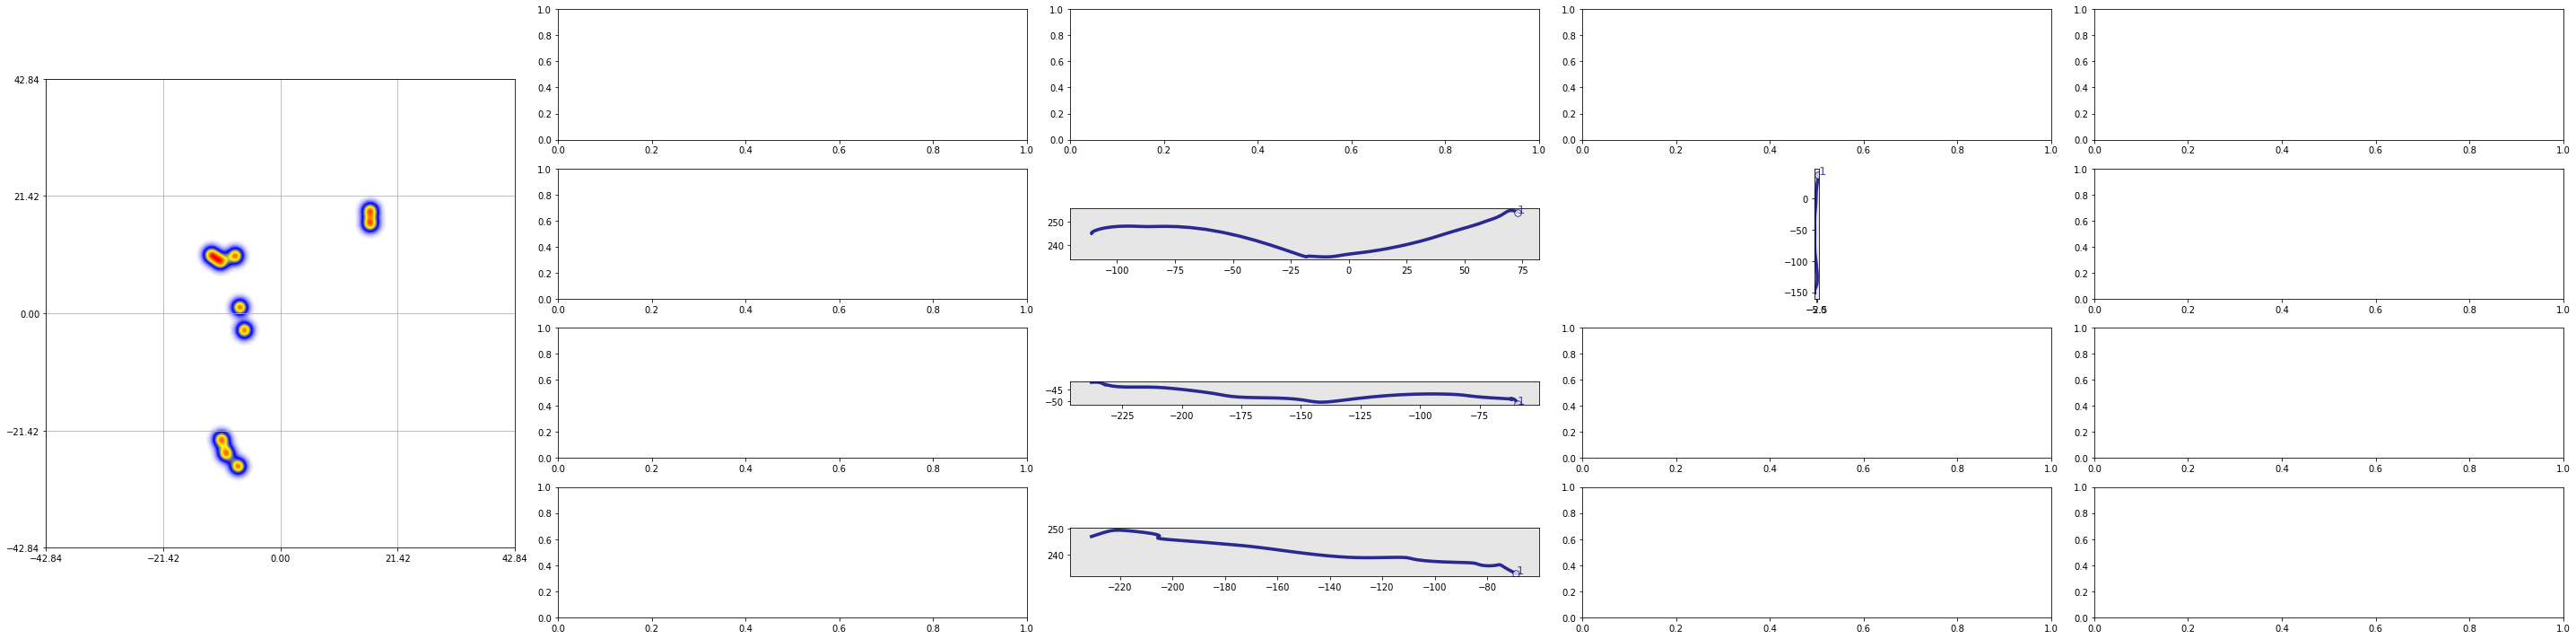

In [445]:
# graphin
#fig, axes = plt.subplots(1, 1, figsize=(10,5))
'''
for i in glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr)):
    zValues = hdf5storage.loadmat(i)['zValues']

m = np.abs(zValues).max()
'''
zValues = hdf5storage.loadmat(glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr))[0])['zValues'][0]

zValues = get_zValues_array(zValues)
zValues = np.array(zValues)

m = np.abs(ally).max()

sigma=1.0
_, xx, density = mmpy.findPointDensity(zValues, sigma, 511, [-m-15, m+15])

#axes.imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

#axes.axis('off')
#axes[0].set_title('Method : %s'%parameters.method)

#sc = axes.scatter([],[],marker='o', color='k', s=5)

#idx = 9
#trial,strokenum = list_trialstroke[idx]
#s = D.Dat.iloc[trial]["strokes_beh"][strokenum]
#D.plotMultStrokes([[s]])
#fig, axes = plt.subplots(1, 1, figsize=(10,5))
#axes.imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

'''
ax00
ax02 x = -40, y = 60
ax03 x = -20, y = 60
ax04 x = 0, y = 60
ax05
ax06
ax07
ax12 x = -40, y = 40
ax13

.
.
ax57
'''

uplim = round((xx[-1]),-1)

print(uplim)

rows = int(uplim/10)

print(rows)

dcol = int(round(rows/3))

print(dcol)

cols = rows +dcol

print(cols)

fig, axes = plt.subplots(rows, cols, figsize=(40,10))

ax00 = plt.subplot2grid((rows,cols),(0,0),rowspan=rows, colspan=dcol)

ax00.imshow(density, cmap=mmpy.gencmap(), extent=(xx[0],xx[-1],xx[0], xx[-1]), origin='lower')
#ax00.grid()
#print(rows)
#print(cols)
#print(dcol)
arrx, arry = divide_strokes(zValues, rows+1, xx[0])

ax00.set_xticks(arrx)
ax00.set_yticks(arry)

ax00.grid()
 #print(arrx)
#print(arry)

#keep calling functions to plot stuff
for r in range(rows):
    for c in range(dcol, cols):
      #print(i)
       #print(r)
         #print(c)
        ax = plt.subplot2grid((rows, cols,), (r,c))
        #y = int(uplim - r*20)
        #print(y)
        #x = int(-uplim + (c-1)*20)
        #print(x)
        ls = strokes_in_area(zValues, arrx, arry, c-dcol, r)
        #print(ls)
        if (len(ls)>0):
            st = choose_stroke(ls)
            #print(st)
            idx = get_sindex(zValues, st)
            #print(idx[0])
            plot_stroke(idx, ax)


'''
ax02 = plt.subplot2grid((6,8),(0,2),colspan=1)
plot_stroke(3,ax02)

ax03 = plt.subplot2grid((6,8),(0,3),colspan=1)
plot_stroke(4,ax03)

ax04 = plt.subplot2grid((6,8),(0,4),colspan=1)
plot_stroke(13,ax04)

ax05 = plt.subplot2grid((6,8),(0,5),colspan=1)
plot_stroke(15,ax05)


ax06 = plt.subplot2grid((6,8),(0,6),colspan=1)
plot_stroke(17,ax06)


ax07 = plt.subplot2grid((6,8),(0,7),colspan=1)
plot_stroke(19,ax07)

ax12 = plt.subplot2grid((6,8),(1,2),colspan=1)
plot_stroke(23,ax13)
'''
plt.tight_layout()  

plt.show()



'''
def show_stroke(z):
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')
    sc = axes.scatter([],[],marker='o', color='k', s=3)
    idx = z
    trial,strokenum = list_trialstroke[z]
    s = D.Dat.iloc[trial]["strokes_beh"][strokenum]
    D.plotMultStrokes([[s]])
    sc.set_offsets(zValues[z])


    for z in range (len(zValues)):
        idx = z
        trial,strokenum = list_trialstroke[z]
        s = D.Dat.iloc[trial]["strokes_beh"][strokenum]
        D.plotMultStrokes([[s]])
        sc.set_offsets(zValues[z])


def showing(t):    
    for z in range(len(zValues)):
        show_stroke(z)

'''



#anim = VideoClip(animate, duration=2)
#plt.close()
#anim.ipython_display(fps=15, loop=True, autoplay=True, maxduration=120)



'''
h5ind = 0
tstart = 0
connections = [np.arange(6,10), np.arange(10,14), np.arange(14,18), np.arange(18,22), np.arange(22,26), np.arange(26,30),
              [2,0,1],[0,3,4,5], [31,3,30]]

def animate(t):
  t = int(t*clips[h5ind].fps)+tstart
  axes[1].clear()
  im = axes[1].imshow(clips[h5ind].get_frame(t/clips[h5ind].fps), cmap='Greys', origin='lower')
  for conn in connections:
      axes[1].plot(h5s[h5ind][t, conn, 0], h5s[h5ind][t, conn, 1], 'k-')
  axes[1].axis('off')
  sc.set_offsets(zValues[20000*h5ind+t])
  return mplfig_to_npimage(fig) #im, ax


anim = VideoClip(animate, duration=2) # will throw memory error for more than 100.
plt.close()
anim.ipython_display(fps=15, loop=True, autoplay=True, maxduration=120)

'''

In [39]:
parameters.projectPath

'content/trial1_mmpy220721_122012'

1/1 Loading embedding for test_monkey_notpca 0.00 seconds.
(10, 2)
1
1
(10, 2)
Starting watershed transform...
Assigning watershed regions...
Calculating velocity distributions...
Initialization 0
Initialization converged: True
	 tempsave done.
Adjusting non-stereotypic regions to 0...
	 Done. 0.00 seconds
	 tempsave done.
All data saved in TSNE/zVals_wShed_groups.mat.


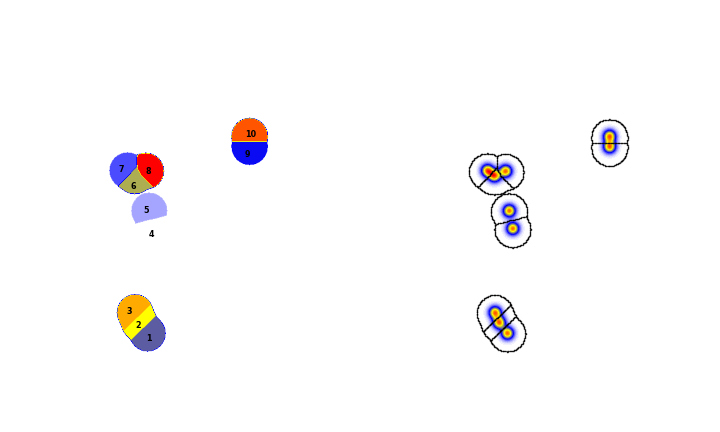

In [485]:
# watershed things
#modifying startsigma because 4.2 was too high
#modifying minimum_regions because 50 was too high
startsigma = 1.0 if parameters.method == 'TSNE' else 2.0
mmpy.findWatershedRegions(parameters, minimum_regions=10, startsigma=startsigma, pThreshold=[0.33, 0.67],
                     saveplot=True, endident = '*_notpca.mat')

Image(glob.glob('%s/%s/zWshed*.png'%(parameters.projectPath, parameters.method))[0])

In [41]:
# function to return array of indexes of the strokes contained in a certain grid of density
def wstrokes_in_area(zValues,wregions,nr):
    lsindex = []
    for i in range(len(zValues)):
        if (wregions[i] == nr):
            lsindex.append(zValues[i])
    return lsindex

C:\Users\18313\AppData\Local\Temp\ipykernel_47640\1021597427.py:53: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


"\nimport glob\nimport matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\n%matplotlib inline\n\nimages = []\nfor img_path in glob.glob('folder/*.png'):\n    images.append(mpimg.imread(img_path))\n\nplt.figure(figsize=(20,10))\ncolumns = 5\nfor i, image in enumerate(images):\n    plt.subplot(len(images) / columns + 1, columns, i + 1)\n    plt.imshow(image)\n"

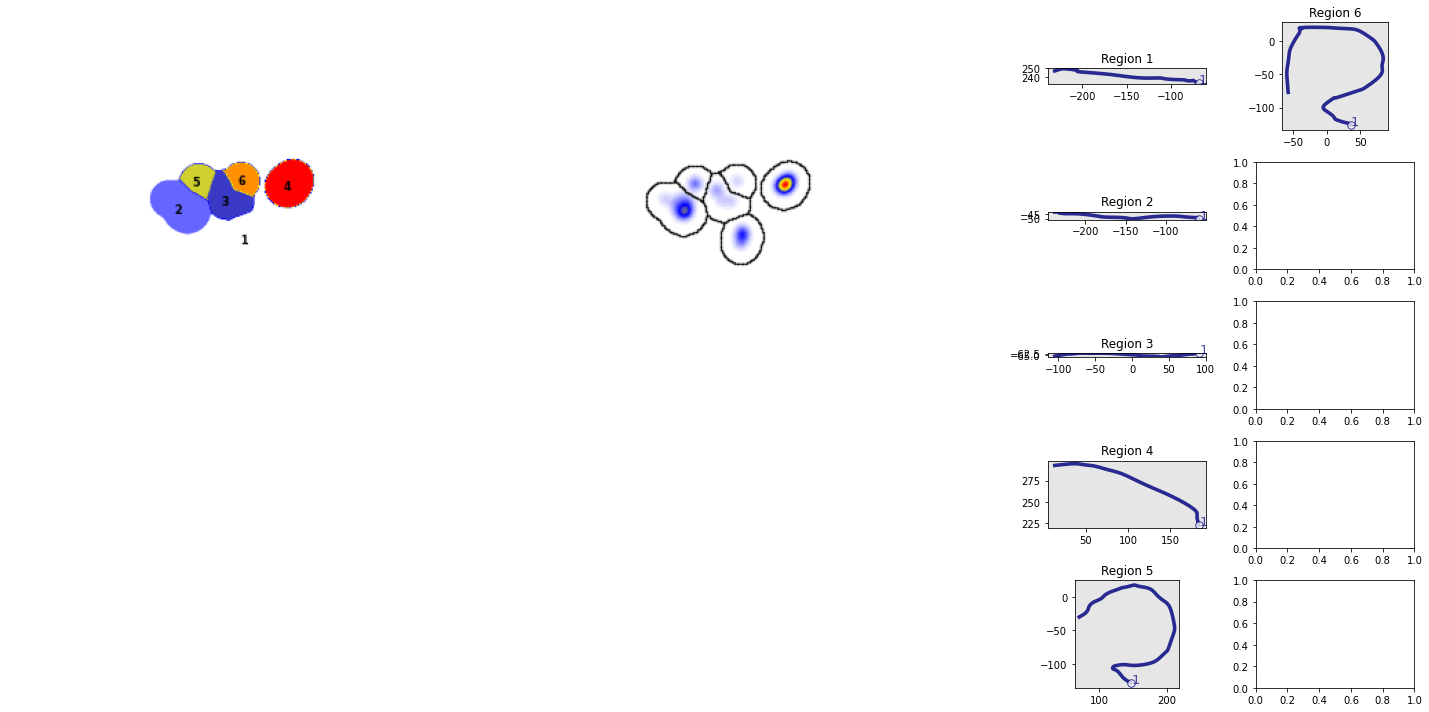

In [81]:
# do the same for watershed
#from IPython.display import Image
#Image(glob.glob('%s/%s/zWshed*.png'%(parameters.projectPath, parameters.method))[0])

wshedfile = hdf5storage.loadmat('%s/%s/zVals_wShed_groups.mat'%(parameters.projectPath, parameters.method))

wregions = wshedfile["indexesWatershedRegions"][0]

nregions = wregions.max()

# calculate how many columns and rows
# 10 rows and add more columns as needed
# figure out how to name plot

rows = 5
dcol = int(round(rows/1))
cols = math.ceil(nregions/rows) + dcol

fig, axes = plt.subplots(rows, cols, figsize=(20,10))


ax00 = plt.subplot2grid((rows,cols),(0,0),rowspan=rows, colspan=dcol)

ax00.imshow(mpimg.imread(glob.glob('%s/%s/zWshed*.png'%(parameters.projectPath, parameters.method))[0]))
ax00.axis('off')

#ax00.set(xlim=(-60, 60))
#ax00.set(ylim = (-60, 60))
#ax00.set_xticks(arrx)

#sc = ax00.scatter([],[],marker='o', color='k', s=3)
#sc.set_offsets(zValues[9])

#keep calling functions to plot stuff

# for every region
# plot one random stroke

for r in range(rows):
    for c in range(dcol, cols):
        nr = (c-dcol)*rows + r + 1
        ax = plt.subplot2grid((rows, cols), (r, c))
        ls = wstrokes_in_area(zValues, wregions, nr)
        if (len(ls)>0):
            st = choose_stroke(ls)
            idx = get_sindex(zValues, st)
            plot_stroke(idx, ax)
            ax.set_title('Region '+str(nr))
            #ax.title()
        
plt.tight_layout()  
plt.show()


'''
#keep calling functions to plot stuff
for r in range(rows):
    for c in range(dcol, cols):
      #print(i)
       #print(r)
         #print(c)
        ax = plt.subplot2grid((rows, cols,), (r,c))
        #y = int(uplim - r*20)
        #print(y)
        #x = int(-uplim + (c-1)*20)
        #print(x)
        ls = strokes_in_area(zValues, arrx, arry, c-2, r)
        #print(ls)
        if (len(ls)>0):
        
            st = choose_stroke(ls)
            #print(st)
            idx = get_sindex(zValues, st)
            #print(idx[0])
            plot_stroke(idx, ax)
'''
#asda
'''
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('folder/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
'''

In [83]:
# function to choose sample of strokes from the index list and return it
def choose_sample_strokes(lsindex, ni):
    if (ni > len(lsindex)):
        ni = len(lsindex)
    lsample = random.sample(lsindex, ni)
    return lsample

In [119]:
def many_strokes_in_region(zValues, wregions, nr, ns):
    wshedfile = hdf5storage.loadmat('%s/%s/zVals_wShed_groups.mat'%(parameters.projectPath, parameters.method))
    wregions = wshedfile["indexesWatershedRegions"][0]
    
    ls = wstrokes_in_area(zValues, wregions, nr)
    if (len(ls)>0):
        lsample = choose_sample_strokes(ls, ns)

        nstrokes = len(lsample)

        rows = 5
        dcol = int(round(rows/1))
        cols = math.ceil(nstrokes/rows) + dcol

        fig, axes = plt.subplots(rows, cols, figsize=(20,10))


        ax00 = plt.subplot2grid((rows,cols),(0,0),rowspan=rows, colspan=dcol)

        ax00.imshow(mpimg.imread(glob.glob('%s/%s/zWshed*.png'%(parameters.projectPath, parameters.method))[0]))
        ax00.axis('off')
        
        print(lsample)

        for r in range(rows):
            for c in range(dcol, cols):
                ax = plt.subplot2grid((rows, cols), (r, c))
                s = (c-dcol)*rows + r
                if (len(lsample)>s):
                    if (len(lsample)>0):
                        print(lsample[s])
                        st = lsample[s]
                    else:
                        st = lsample[0]
                    idx = get_sindex(zValues, st)
                    plot_stroke(idx, ax)
                    ax.set_title('Region '+str(nr))
                    #ax.title()

        plt.tight_layout()  
        plt.show()
    
    
    
    
    
    
    

[array([-2.70411237, 35.8074695 ])]
[-2.70411237 35.8074695 ]


C:\Users\18313\AppData\Local\Temp\ipykernel_47640\1346452544.py:41: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


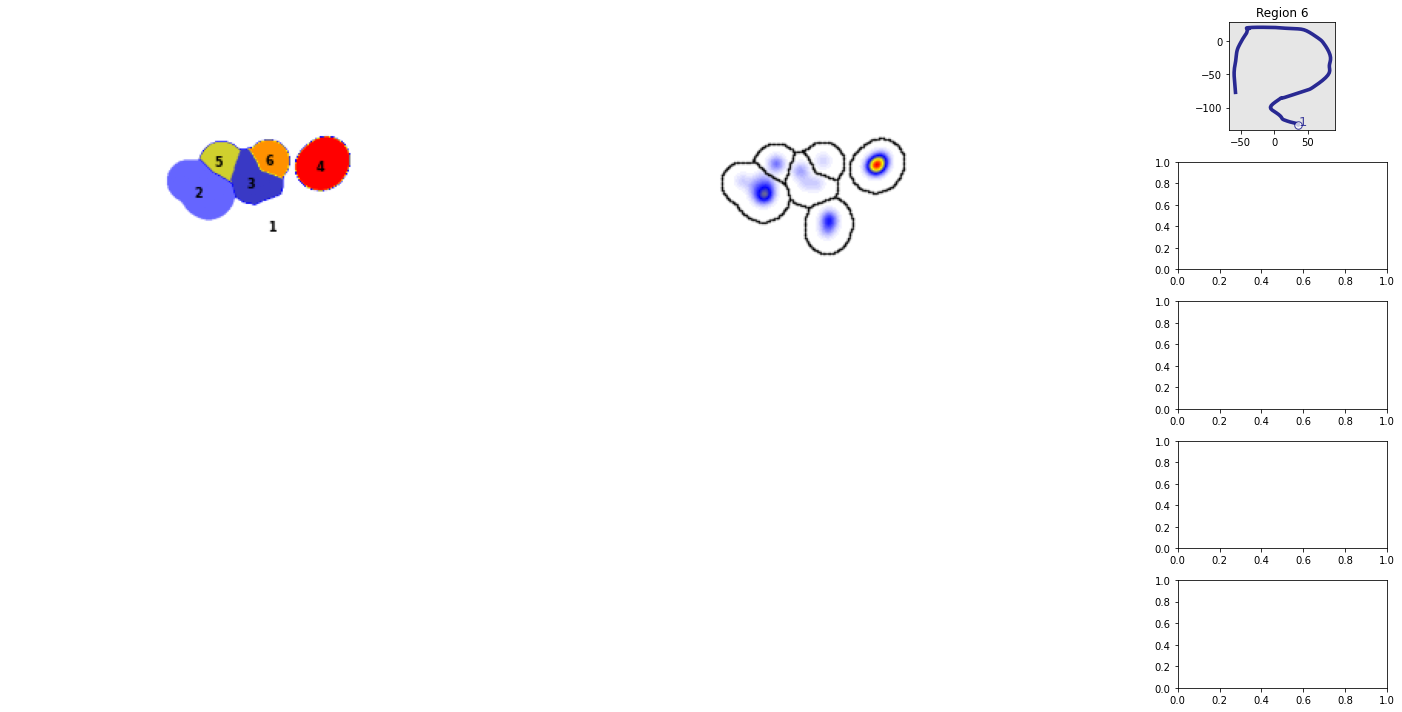

In [135]:
many_strokes_in_region(zValues, wregions, 6, 50)

In [137]:
zValues.shape

(51, 2)